# QOSF Mentorship - Screening Task 1

### Contestant Details -

Name - Nishal Kulkarni

E-mail Address - nishalkulkarni@gmail.com

Repo link - https://github.com/nishalkulkarni/QOSF_Screening_Task_1

In [1]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector
from qiskit.quantum_info import random_statevector
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import time

## Building the Circuit
For every layer we use N\*2 parameters, where N = number of qubits in our circuit.

Therefore in total we have (N\*2)\*L parameters where L = number of layers (1 layers = 1 odd block + 1 even block)

In [2]:
def build_template(N, L, theta):
    circuit = QuantumCircuit(N)
    count = 0
    for _ in range(L):
        # Odd block
        for j in range(N):
            circuit.rx(theta[count],j)
            count+=1
        
        # Even block
        for j in range(N):
            circuit.rz(theta[count],j)
            count+=1
        for i in range(N):
            for j in range(i+1,N):
                    circuit.cz(i,j)
        
        circuit.barrier()
    return circuit

Here's the circuit built for 4 qubits and 2 Layers, we also pass a ParameterVector consisteing of (N\*2)\*L elements

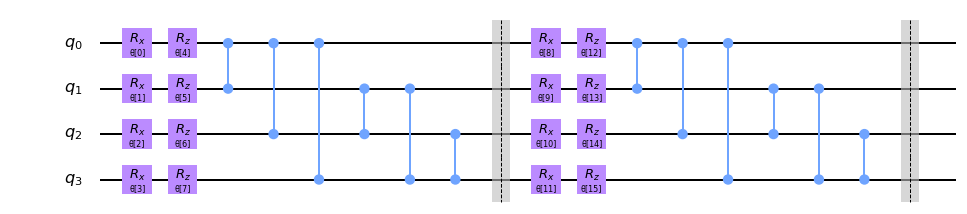

In [3]:
build_template(N=4,L=2,theta=ParameterVector("θ",(4*2)*2)).draw()

## Helper functions
The get_statevector() function takes in a circuit and simulates it using qiskit's inbuilt statevector simulator backend and finally return the results as a list

In [4]:
def get_statevector(psi):
    backend = Aer.get_backend('statevector_simulator')
    result = execute(psi, backend).result()
    sv = result.get_statevector()
    return sv

To get a randomly generated vector on N qubits we use qiskit's inbuilt random_statevector() function which generates a statevector and return the list obtained. The statevector produced by N qubits should be of size $2^N$.

In [5]:
def get_random_phi(N):
    random_phi = random_statevector(2**N).data
    return random_phi

To get initial parameters we use a random number generator which generates value between $[0,1]$ and multiply it with $2\pi$ so as to get value in range of $[0,2\pi]$

In [6]:
def get_initial_params(N,L):
    initial_params = list()
    for i in range((N*2)*L):
        initial_params.append(np.random.rand()*2*np.pi)
    return initial_params

The change_params() function creates and returns a new circuit based on an existing template and assigns all the parameters to the one's given in new_params.

In [7]:
def change_params(psi_template,theta,new_params):
    psi_assigned = psi_template
    for i in range(len(new_params)):
        psi_assigned = psi_assigned.assign_parameters({theta[i]:new_params[i]})
    return psi_assigned

To get the distance for a particular statevector we use the get_epsilon() function which takes in the statevector along with the randomly generated vector phi. 

In [8]:
def get_epsilon(result,random_phi):
    e_theta = result - random_phi
    epsilon = 0
    for i in e_theta:
        epsilon += (i*np.conj(i)).real
    return np.sqrt(epsilon)

The circuit_to_epsilon function creates a circuit and assigns all the parameters, it calculates and returns epsilon for given parameters(params). This will be used by the find_minima function to arrive at the optimal parameters

In [9]:
def circuit_to_epsilon(params,N,L,phi):
    theta = ParameterVector("theta",(N*2)*L)
    psi_template = build_template(N,L,theta)
    psi_circuit = change_params(psi_template,theta,params)
    epsilon = get_epsilon(get_statevector(psi_circuit),phi)
    return epsilon

The find_minima function is used to find the minimum distance for a particular circuit. It requires **4 parameters**

* **N** - Number of qubits
* **L** - Number of layers
* **phi** - the random generated vetor on N qubits 
* **current_params** - initial parameters from which the minimization is to be performed

And has 4 hyperparameters -
* **learning_rate** (default = 0.05) 
* **delta** (default = 0.01) 
* **tolerance** (default = $10^{-4}$)
* **momentum** (default = 0.8) 

We use **Gradient Descent with Nesterov Accelerated Momentum** to optimize the parameters and find the minimum epsilon [distance].

**Note**: It is possible to get stuck at a local minima.

In [68]:
def find_minima(N,L,phi,current_params,learning_rate=0.05,delta=0.01,tolerance=1e-4,momentum=0.8):
    diff = 1 
    iterations = 0 
    params_len = len(current_params) 
    momentum_update = [0 for i in range (params_len)]

    while(abs(diff)>tolerance):
        iterations +=1 
        # Getting actual value for epsilon 
        epsilon_prev = circuit_to_epsilon(current_params,N,L,phi)

        gradient = [0 for i in range (params_len)]

        # We find partial derivative by first principle, delta being the small update.
        for i in range(len (current_params)):
            new_params = current_params[:] 
            new_params[i] = (current_params[i] + delta + momentum*momentum_update[i])%(2*np.pi) # mod by 2*pi (sticking to constraints]
 
            epsilon_next = circuit_to_epsilon(new_params,N,L,phi)

            gradient[i] = (epsilon_next-epsilon_prev)/delta

        # Updating Parameters to get predicted value of epsilon 
        momentum_update = momentum*np.array(momentum_update) - learning_rate*np.array(gradient)
        final_params = [current_params[i] + momentum_update[i] for i in range(params_len)]

        epsilon_final = circuit_to_epsilon(final_params,N,L,phi)     
        
        current_params = final_params[:]
        diff = epsilon_final - epsilon_prev 
                

    return epsilon_final,final_params,iterations

## Testing & Results

We find minimum distance for upto 6 layered circuits. As the optimizer used is not efficient this might take some time.

Number of Layers - 1, Final epsilon - 0.984235612540, Time taken - 16.67s
Number of Layers - 2, Final epsilon - 0.522358508610, Time taken - 37.38s
Number of Layers - 3, Final epsilon - 0.214597465789, Time taken - 320.84s
Number of Layers - 4, Final epsilon - 0.045164434209, Time taken - 575.10s
Number of Layers - 5, Final epsilon - 0.071549587393, Time taken - 722.75s
Number of Layers - 6, Final epsilon - 0.063657849315, Time taken - 1005.56s


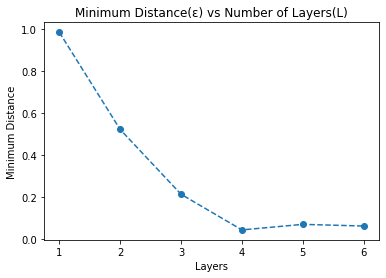

In [69]:
N = 4 # Number of qubits
MAX_LAYERS = 6 # Total number of layers
min_distances = list()
optimal_parameters = list()
iterations_per_layer = list()
time_per_layer = list()
phi = get_random_phi(N) # Same phi used for all L layered circuits
       
for L in range(1,MAX_LAYERS+1):
    initial_params = get_initial_params(N,L)
    
    start_time = time.time()
    final_epsilon,final_params,iterations = find_minima(N,L,phi,initial_params)
    end_time = time.time()
    
    min_distances.append(final_epsilon)
    optimal_parameters.append(final_params)
    iterations_per_layer.append(iterations)
    time_per_layer.append(end_time - start_time)
    print("Number of Layers - %d, Final epsilon - %.12f, Time taken - %.2fs"%(L,final_epsilon,time_per_layer[-1]))

# Plotting Results for Minimum Distance
plt.plot(list(range(1,MAX_LAYERS+1)),min_distances,'o--')
plt.xlabel("Layers")
plt.ylabel("Minimum Distance")
plt.title("Minimum Distance(ε) vs Number of Layers(L)")
plt.show()

We can infer from the graph that the minimum distance between $\psi$ and $\phi$ is directly proportional to the number of layers, hence it is directly proportional to the number of parameters. Initially the minimum distance $\epsilon$ decreases rapidly as the number of layers increase, after a certain point we see stabilization and no significant decrease in distance is observed.

We try finding relation between time taken, number of iterations and number of layers below -

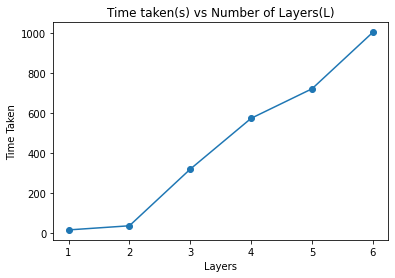

In [70]:
# Plotting Results for time
plt.plot(list(range(1,MAX_LAYERS+1)),time_per_layer,'o-')
plt.xlabel("Layers")
plt.ylabel("Time Taken")
plt.title("Time taken(s) vs Number of Layers(L)")
plt.show()

As we can see from the above plot, time taken increases for every additional layer. This is because of increasing number of parameters.

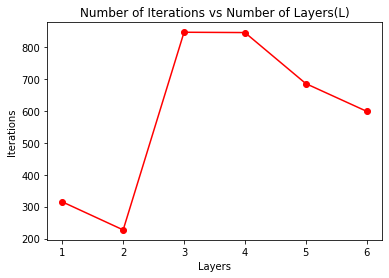

In [71]:
# Plotting Results for number of iterations
plt.plot(list(range(1,MAX_LAYERS+1)),iterations_per_layer,'ro-')
plt.xlabel("Layers")
plt.ylabel("Iterations")
plt.title("Number of Iterations vs Number of Layers(L)")
plt.show()

The reason we see no strong correlation between between the number of iterations and number of layers might be because of the poor optimizer.

# Bonus Question - Using other gates for the parametrized gates 

**Case #1** - Replacing Rz with Ry gates

In [73]:
def build_circuit_rzy(N, L, theta):
    circuit = QuantumCircuit(N)
    count = 0
    for _ in range(L):
        # Odd block
        for j in range(N):
            circuit.rx(theta[count],j)
            count+=1
        
        # Even block
        for j in range(N):
            circuit.ry(theta[count],j)
            count+=1
        for i in range(N):
            for j in range(i+1,N):
                    circuit.cz(i,j)
        
        circuit.barrier()
    return circuit

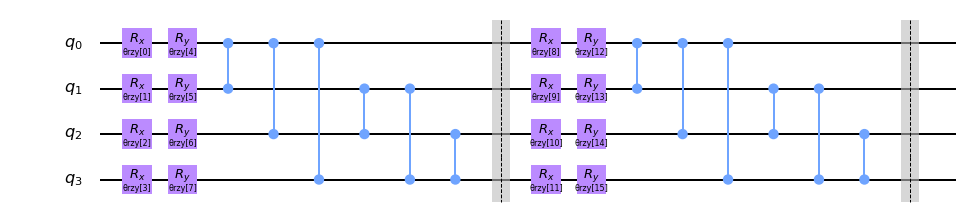

In [74]:
build_circuit_rzy(N=4,L=2,theta=ParameterVector("θrzy",(4*2)*2)).draw()

In [78]:
def rzy_circuit_to_epsilon(params,N,L,phi):
    theta = ParameterVector("theta",(N*2)*L)
    psi_template = build_circuit_rzy(N,L,theta)
    psi_circuit = change_params(psi_template,theta,params)
    epsilon = get_epsilon(get_statevector(psi_circuit),phi)
    return epsilon

Unlike before where we used a custom optimizer to find the minimum distance, here we use **SciPy's inbuilt minimize function** to get the optimal parameters. Also we perform optimization upto 4 layers.

Number of Layers - 1, Final epsilon - 1.730490758520, Time taken - 8.35s
Number of Layers - 2, Final epsilon - 0.436964020616, Time taken - 13.98s
Number of Layers - 3, Final epsilon - 0.347391487983, Time taken - 54.45s
Number of Layers - 4, Final epsilon - 0.000808265285, Time taken - 320.67s


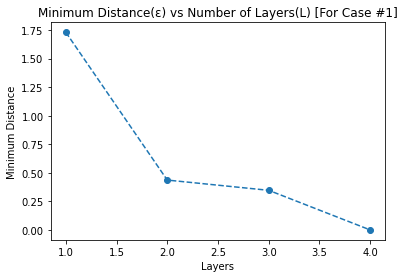

In [79]:
N = 4 # Number of qubits
MAX_LAYERS = 4 # Total number of layers
min_distances = list()
time_per_layer = list()
phi = get_random_phi(N) # Same phi used for all L layered circuits
       
for L in range(1,MAX_LAYERS+1):
    initial_params = get_initial_params(N,L)
    
    num_params = (N*2)*L
    bounds = [(0,2*np.pi)]*num_params

    start_time = time.time()
    result = minimize(rzy_circuit_to_epsilon,initial_params,args=(N,L,phi),bounds=bounds)
    end_time = time.time()
    
    min_distances.append(result.fun)
    time_per_layer.append(end_time - start_time)
    print("Number of Layers - %d, Final epsilon - %.12f, Time taken - %.2fs"%(L,result.fun,time_per_layer[-1]))

# Plotting Results for Minimum Distance
plt.plot(list(range(1,MAX_LAYERS+1)),min_distances,'o--')
plt.xlabel("Layers")
plt.ylabel("Minimum Distance")
plt.title("Minimum Distance(ε) vs Number of Layers(L) [For Case #1]")
plt.show()

A similar trend is observed, the minimum distance decreases as the number of layers increase even after replacing all the Rz gates with Ry

**Case #2** - Replacing Rx with Ry gates

In [81]:
def build_circuit_rxy(N, L, theta):
    circuit = QuantumCircuit(N)
    count = 0
    for _ in range(L):
        # Odd block
        for j in range(N):
            circuit.ry(theta[count],j)
            count+=1
        
        # Even block
        for j in range(N):
            circuit.rz(theta[count],j)
            count+=1
        for i in range(N):
            for j in range(i+1,N):
                    circuit.cz(i,j)
        
        circuit.barrier()
    return circuit

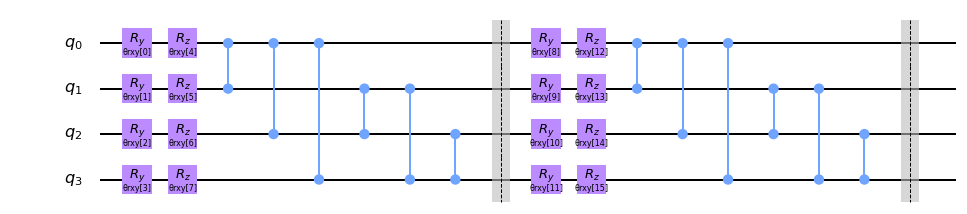

In [82]:
build_circuit_rxy(N=4,L=2,theta=ParameterVector("θrxy",(4*2)*2)).draw()

In [84]:
def rxy_circuit_to_epsilon(params,N,L,phi):
    theta = ParameterVector("theta",(N*2)*L)
    psi_template = build_circuit_rxy(N,L,theta)
    psi_circuit = change_params(psi_template,theta,params)
    epsilon = get_epsilon(get_statevector(psi_circuit),phi)
    return epsilon

Number of Layers - 1, Final epsilon - 0.831293000917, Time taken - 0.88s
Number of Layers - 2, Final epsilon - 0.333375167315, Time taken - 9.60s
Number of Layers - 3, Final epsilon - 0.238243864475, Time taken - 190.01s
Number of Layers - 4, Final epsilon - 0.035627560321, Time taken - 174.63s


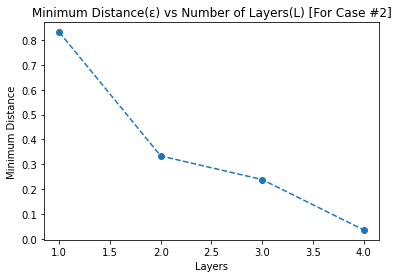

In [85]:
N = 4 # Number of qubits
MAX_LAYERS = 4 # Total number of layers
min_distances = list()
time_per_layer = list()
phi = get_random_phi(N) # Same phi used for all L layered circuits
       
for L in range(1,MAX_LAYERS+1):
    initial_params = get_initial_params(N,L)
    
    num_params = (N*2)*L
    bounds = [(0,2*np.pi)]*num_params

    start_time = time.time()
    result = minimize(rxy_circuit_to_epsilon,initial_params,args=(N,L,phi),bounds=bounds)
    end_time = time.time()
    
    min_distances.append(result.fun)
    time_per_layer.append(end_time - start_time)
    print("Number of Layers - %d, Final epsilon - %.12f, Time taken - %.2fs"%(L,result.fun,time_per_layer[-1]))

# Plotting Results for Minimum Distance
plt.plot(list(range(1,MAX_LAYERS+1)),min_distances,'o--')
plt.xlabel("Layers")
plt.ylabel("Minimum Distance")
plt.title("Minimum Distance(ε) vs Number of Layers(L) [For Case #2]")
plt.show()

Again we notice a similar trend after replacing the Rx gates with Ry gate.

**Conclusion**: For the given circuit we see that distance decreases drastically as the number of layers increase, after a certain number of layers we don't notice such drastic decrease and stabilization of $\epsilon$ is observed. This trend hold true even after replacing the Rx or the Rz gates with Ry gates.